In [1]:
import torch
import sys
import os.path as osp
import os
import sys
import numpy as np
sys.path.append("/eos/home-g/gkrzmanc/jetclustering/code")
from src.dataset.dataset import SimpleIterDataset
from src.utils.utils import to_filelist
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch_scatter import scatter_sum
import matplotlib.pyplot as plt
import pickle
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)

In [46]:
def remove_from_list(lst):
    out = []
    for item in lst:
        if item in ["hgcal", "data.txt", "test_file.root"]:
            continue
        out.append(item)
    return out

path = "/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak"

datasets = os.listdir(path)
datasets = [os.path.join(path, x) for x in datasets]
datasets = datasets[:5]

class Args:
    def __init__(self):
        self.data_train = datasets
        self.data_val = datasets
        #self.data_train = files_train
        self.data_config = '/eos/home-g/gkrzmanc/jetclustering/code/config_files/config_jets.yaml'
        self.extra_selection = None
        self.train_val_split = 0.8
        self.data_fraction = 1
        self.file_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.2
        self.steps_per_epoch = None
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.no_remake_weights = False
        self.batch_size = 10
        self.num_workers = 0
        self.demo = False
        self.laplace = False
        self.diffs = False
        self.class_edges = False

args = Args()
train_range = (0, args.train_val_split)
train_file_dict, train_files = to_filelist(args, 'train')
train_data = SimpleIterDataset(train_file_dict, args.data_config, for_training=True,
                               extra_selection=args.extra_selection,
                               remake_weights=True,
                               load_range_and_fraction=(train_range, args.data_fraction),
                               file_fraction=args.file_fraction,
                               fetch_by_files=args.fetch_by_files,
                               fetch_step=args.fetch_step,
                               infinity_mode=False,
                               in_memory=args.in_memory,
                               async_load=False,
                               name='train', jets=True)

iterator = iter(train_data)


['/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak/PFNano_s-channel_mMed-700_mDark-20_rinv-0.7_alpha-peak_13TeV-pythia8_n-1000_part-1.root', '/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak/PFNano_s-channel_mMed-700_mDark-20_rinv-0.7_alpha-peak_13TeV-pythia8_n-1000_part-10.root', '/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak/PFNano_s-channel_mMed-700_mDark-20_rinv-0.7_alpha-peak_13TeV-pythia8_n-1000_part-11.root', '/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak/PFNano_s-channel_mMed-700_mDark-20_rinv-0.7_alpha-peak_13TeV-pythia8_n-1000_part-12.root', '/eos/user/g/gkrzmanc/jetclustering/data/SVJ_std_UL2018_scouting_test_large/SVJ_mMed-700GeV_mDark-20GeV_rinv-0.7_alpha-peak/PFNano_s-channel

In [61]:
data = next(iterator)

Jet idx: [0.]
PFCands_idx: [0.]
Jet idx: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 2. 1. 1. 2. 2. 1. 2. 2. 2. 0. 0. 1. 1. 0. 0. 0. 0. 1. 2. 2. 1. 1. 1.
 1. 2. 2. 0. 0. 0. 2. 0. 0. 1. 2. 0. 1. 1. 2. 0. 1. 1. 2. 2. 0. 2. 2. 2.
 0. 2. 2. 2. 1. 2. 2. 2. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 2. 1. 0. 1. 0. 0. 1. 2. 2. 1. 0. 2. 2. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 2. 1. 1. 0. 1. 2. 0. 2. 0. 2. 0. 0. 0. 2. 1. 2. 1. 2. 1. 0.
 1. 1. 1. 2. 2. 0. 0. 0. 0. 0. 0. 1. 2. 2. 2. 0. 2. 2. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 

In [62]:

eta = data["pfcands"].eta
phi = data["pfcands"].phi
pt = data["pfcands"].pt
mapping = data["pfcands"].pf_cand_to_jet
offline_eta = data["offline_pfcands"].eta
offline_phi = data["offline_pfcands"].phi
offline_pt = data["offline_pfcands"].pt
offline_mapping = data["offline_pfcands"].pf_cand_to_jet

genjet_eta = data["genjets"].eta
genjet_phi = data["genjets"].phi
genjet_pt = data["genjets"].pt


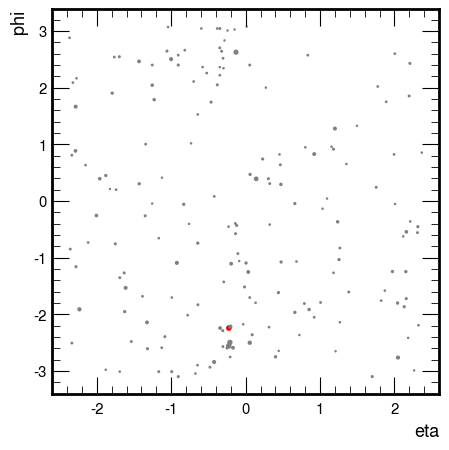

In [63]:
fig, ax = plt.subplots(figsize=(5,5))
# plot eta, phi and the size of circles proportional to p_t. The colors should be either gray (if not in mapping) or some other color that 'represents' the identified jet

colorlist = ["red", "green", "blue"]
colors = []
for i in range(len(eta)):
    if i in mapping:
        colors.append(colorlist[mapping[i]])
    else:
        colors.append("gray")

ax.scatter(eta, phi, s=pt, c=colors)
ax.scatter(genjet_eta, genjet_phi, marker="*", s=genjet_pt, c="blue", alpha=1.0)
ax.set_xlabel("eta")
ax.set_ylabel("phi")
fig.show()

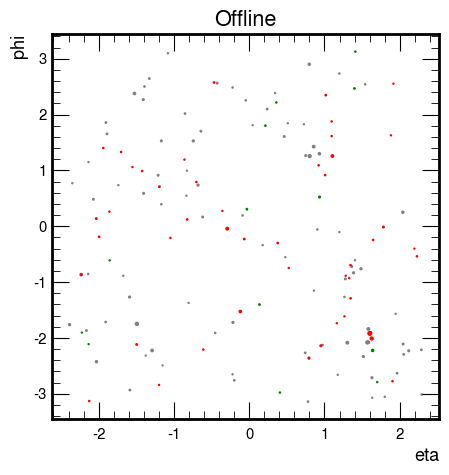

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
# plot eta, phi and the size of circles proportional to p_t. The colors should be either gray (if not in mapping) or some other color that 'represents' the identified jet

colorlist = ["red", "green", "blue", "purple", "orange", "white", "white", "white"]
colors = []
for i in range(len(offline_eta)):
    if i in offline_mapping:
        colors.append(colorlist[offline_mapping[i]])
    else:
        colors.append("gray")

ax.scatter(offline_eta, offline_phi, s=offline_pt, c=colors)
ax.set_xlabel("eta")
ax.set_ylabel("phi")
ax.set_title("Offline")
fig.show()

{1: 0,
 8: 0,
 9: 0,
 15: 0,
 17: 0,
 23: 0,
 55: 0,
 70: 0,
 72: 0,
 73: 0,
 83: 0,
 127: 0,
 130: 0,
 145: 0,
 146: 0,
 147: 0,
 148: 0,
 172: 0,
 181: 0,
 7: 1,
 10: 1,
 13: 1,
 18: 0,
 30: 0,
 38: 2,
 50: 1,
 51: 1,
 65: 2,
 66: 2,
 69: 1,
 74: 0,
 78: 0,
 84: 2,
 98: 0,
 104: 2,
 111: 1,
 112: 1,
 116: 0,
 117: 0,
 118: 0,
 120: 0,
 121: 0,
 124: 0,
 132: 2,
 154: 0,
 164: 1,
 165: 0,
 171: 2,
 177: 0,
 178: 0,
 179: 0,
 183: 1,
 188: 0,
 198: 2,
 211: 2,
 217: 2,
 223: 1,
 226: 2,
 229: 1,
 233: 0,
 234: 0,
 238: 2,
 239: 2,
 245: 0,
 264: 1,
 265: 0,
 266: 2,
 269: 1,
 270: 1,
 274: 0,
 283: 1,
 286: 1,
 288: 0,
 292: 1,
 297: 2,
 304: 2}